# Calculating Cooling Degree Days using daily projections from Cal-Adapt API

Cooling degree days (CDDs) and heating degree days (HDDs) are scalar metrics with units of degree-days that proxy the extent to which the average ambient temperature exceeds a reference temperature (thus creating a cooling load) or is below a reference temperature (thus creating a heating load).

Mathematically, CDDs and HDDs are constructed thus for a given location:
* CDDs = Σ[(MAX((Tcentral-Tref),0))×1 day]
* HDDs = Σ[(MAX((Tref –Tcentral),0))×1 day]

…where the summation is over a given number of days, Tcentral represents a central estimate of (approximately “average”) temperature at the location in question and Tref is a reference temperature used for the purposes of the calculation. Typically Tref is 65° F, but some utilities may use other reference temperatures for calculating CDDs and HDDs.

Because daily Tmax and Tmin are more readily available from both modeling and historical observations than is the actual daily average temperature, the Tcentral is typically (and will be in the context of Cal-Adapt) constructed as the “mid-point” temperature that is the average of Tmin and Tmax. 

Begin by importing all python modules we will need.

In [105]:
# A 'magic' command to display plots inline
%matplotlib inline

import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Defining some functions and values that we use later in the code. 

In [2]:
# Convert value from degrees Celsius to degrees Fahrenheit (used for observed data)
def celsius_to_F(val):
    return val * 9/5 + 32 

# Convert value from Kelvin to degrees Fahrenheit (used for modeled data)
def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

# Request header
headers = {'ContentType': 'json'}

### You can get data for a point or an area of your interest

If you are requesting data for a point or polygon use the `g` parameter to specify geometry. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

In [3]:
# Uncomment the following lines to get data for a point location
#point = 'POINT(-121.4687 38.5938)'
#params = {'g': point}

# Uncomment the following lines to get data for a polygon
#polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
#params = {'g': polygon, 'stat': 'mean'}

### If you want to use polygon geometry from Cal-Adapt API, it's a 2-step process

- First get a polygon from a boundary layer in the API (e.g. counties, census tracts, place, etc.) that intersects your point of interest. Build a string that references the id of the polygon.
- Then use the `ref` param instead of the `g` param to request data

[Complete list of boundaries in Cal-Adapt API](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data). **Note: Requests might time out if the polygon is too large**. Subsetting the daily data has been tested with counties, census tracts, places and hydrounits. If you need data for a large boundary we reccomend downloading the daily rasters and processing the data locally. 

In [4]:
# Your point of interest
point = 'POINT(-121.4687 38.5938)'
# Name of boundary layer in API
resource = 'counties'
# Request url
url = 'http://api.cal-adapt.org/api/%s/' % resource
# Request params to find intersecting boundaries
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        print(ref)
    else:
        print('Did not find any polygons that intersect your point')

params = {'ref': ref, 'stat': 'mean'}

/api/counties/34/


### 1. Get observed daily tasmax and tasmin

Daily data is stored as a multiband raster. So the observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01.

In [5]:
# Request url
url = 'http://api.cal-adapt.org/api/series/tasmax_day_livneh/' + 'rasters/'

# Make request
response = requests.get(url, params=params, headers=headers)

# Variable stores observed daily data in a Pandas dataframe
obsTasmaxDF = None

if response.ok:
    json = response.json()
    data = json['results'][0]
    
    # Multiband raster data is returned by the API as a 3D array having a shape (233376, 1, 1)
    # Flatten the 3D array into a 1D array
    values_arr = np.array(data['image'])
    values_arr = values_arr.flatten()
    
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    
    # Get total number of values -> number of days
    length = len(values_arr)
    
    # Create new pandas dataframe and map each value in list to a date index
    obsTasmaxDF = pd.DataFrame(values_arr,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['tasmax'])
    
    # Convert celsius to Fahrenheit
    obsTasmaxDF.tasmax = obsTasmaxDF.tasmax.apply(lambda x: celsius_to_F(x))

print(obsTasmaxDF.head())

               tasmax
1950-01-01  47.537341
1950-01-02  43.417568
1950-01-03  46.940557
1950-01-04  43.705381
1950-01-05  45.215155


In [6]:
# Request url
url = 'http://api.cal-adapt.org/api/series/tasmin_day_livneh/' + 'rasters/'

# Make request
response = requests.get(url, params=params, headers=headers)

# Variable stores observed daily data in a Pandas dataframe
obsTasminDF = None

if response.ok:
    json = response.json()
    data = json['results'][0]
    
    # Multiband raster data is returned by the API as a 3D array having a shape (233376, 1, 1)
    # Flatten the 3D array into a 1D array
    values_arr = np.array(data['image'])
    values_arr = values_arr.flatten()
    
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    
    # Get total number of values -> number of days
    length = len(values_arr)
    
    # Create new pandas dataframe and map each value in list to a date index
    obsTasminDF = pd.DataFrame(values_arr,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['tasmin'])
    
    # Convert celsius to Fahrenheit
    obsTasminDF.tasmin = obsTasminDF.tasmin.apply(lambda x: celsius_to_F(x))

print(obsTasminDF.head())

               tasmin
1950-01-01  31.491361
1950-01-02  32.708124
1950-01-03  25.595154
1950-01-04  23.560784
1950-01-05  22.076433


### 2. Get projected Tasmax & Tasmin for HadGEM2-ES RCP 8.5

In [7]:
# Request url
url = 'http://api.cal-adapt.org/api/series/tasmax_day_HadGEM2-ES_rcp85/' + 'rasters/'

# Make request
response = requests.get(url, params=params, headers=headers)

# Variable stores observed daily data in a Pandas dataframe
projTasmaxDF = None

if response.ok:
    json = response.json()
    data = json['results'][0]
    
    # Multiband raster data is returned by the API as a 3D array having a shape (233376, 1, 1)
    # Flatten the 3D array into a 1D array
    values_arr = np.array(data['image'])
    values_arr = values_arr.flatten()
    
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    
    # Get total number of values -> number of days
    length = len(values_arr)
    
    # Create new pandas dataframe and map each value in list to a date index
    projTasmaxDF = pd.DataFrame(values_arr,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['tasmax'])
    
    # Convert Kelvin to Fahrenheit
    projTasmaxDF.tasmax = projTasmaxDF.tasmax.apply(lambda x: kelvin_to_F(x))

print(projTasmaxDF.head())

               tasmax
2006-01-01  54.075602
2006-01-02  51.549680
2006-01-03  51.462877
2006-01-04  51.992432
2006-01-05  45.609325


In [8]:
# Request url
url = 'http://api.cal-adapt.org/api/series/tasmin_day_HadGEM2-ES_rcp85/' + 'rasters/'

# Make request
response = requests.get(url, params=params, headers=headers)

# Variable stores observed daily data in a Pandas dataframe
projTasminDF = None

if response.ok:
    json = response.json()
    data = json['results'][0]
    
    # Multiband raster data is returned by the API as a 3D array having a shape (233376, 1, 1)
    # Flatten the 3D array into a 1D array
    values_arr = np.array(data['image'])
    values_arr = values_arr.flatten()
    
    # Get start date of timeseries
    start_date = datetime.strptime(data['event'], '%Y-%m-%d')
    
    # Get total number of values -> number of days
    length = len(values_arr)
    
    # Create new pandas dataframe and map each value in list to a date index
    projTasminDF = pd.DataFrame(values_arr,
        index=pd.date_range(start_date, freq='1D', periods=length),
        columns=['tasmin'])
    
    # Convert Kelvin to Fahrenheit
    projTasminDF.tasmin = projTasminDF.tasmin.apply(lambda x: kelvin_to_F(x))

print(projTasminDF.head())

               tasmin
2006-01-01  44.484651
2006-01-02  40.384889
2006-01-03  39.038803
2006-01-04  42.814947
2006-01-05  31.638956


### 3. Calculate Tcentral for projected data

Tcentral = (Tmax + Tmin)/2

In [67]:
projectedDF = pd.concat([projTasmaxDF, projTasminDF], axis=1)
projectedDF.head()

,tasmax,tasmin
2006-01-01,54.075602,44.484651
2006-01-02,51.549680,40.384889
2006-01-03,51.462877,39.038803
2006-01-04,51.992432,42.814947
2006-01-05,45.609325,31.638956


In [110]:
projectedDF['year'] = projectedDF.index.year
projectedDF['month'] = projectedDF.index.month
projectedDF['central'] = (projectedDF['tasmax'] + projectedDF['tasmin'])/2
projectedDF['ref'] = 65
projectedDF['cdd'] = (projectedDF['central'] - projectedDF['ref'])
projectedDF['hdd'] = (projectedDF['ref'] - projectedDF['central'])
projectedDF.head()

,tasmax,tasmin,year,month,central,ref,cdd,hdd
2006-01-01,54.075602,44.484651,2006,1,49.280127,65,-15.719873,15.719873
2006-01-02,51.549680,40.384889,2006,1,45.967285,65,-19.032715,19.032715
2006-01-03,51.462877,39.038803,2006,1,45.250840,65,-19.749160,19.749160
2006-01-04,51.992432,42.814947,2006,1,47.403689,65,-17.596311,17.596311
2006-01-05,45.609325,31.638956,2006,1,38.624141,65,-26.375859,26.375859


In [113]:
cddDF = projectedDF.loc[projectedDF.cdd > 0]
cddDF = cddDF[['year', 'month', 'cdd']].copy()
hddDF = projectedDF.loc[projectedDF.hdd > 0]
hddDF = hddDF[['year', 'month', 'hdd']].copy()

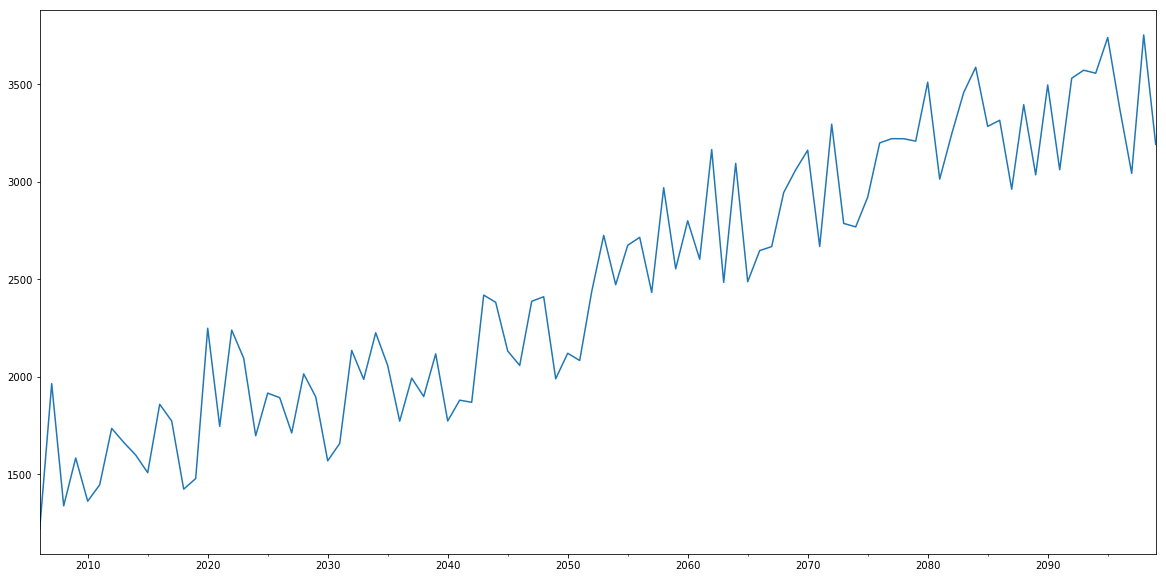

In [116]:
cddDF.cdd.resample('1AS').sum().plot()

In [107]:
cddDF_monthly = pd.DataFrame(cddDF.groupby(['year', 'month'])['cdd'].count())
cddDF_monthly = cddDF_monthly.stack().unstack(1)
cddDF_monthly = cddDF_monthly.fillna(0)

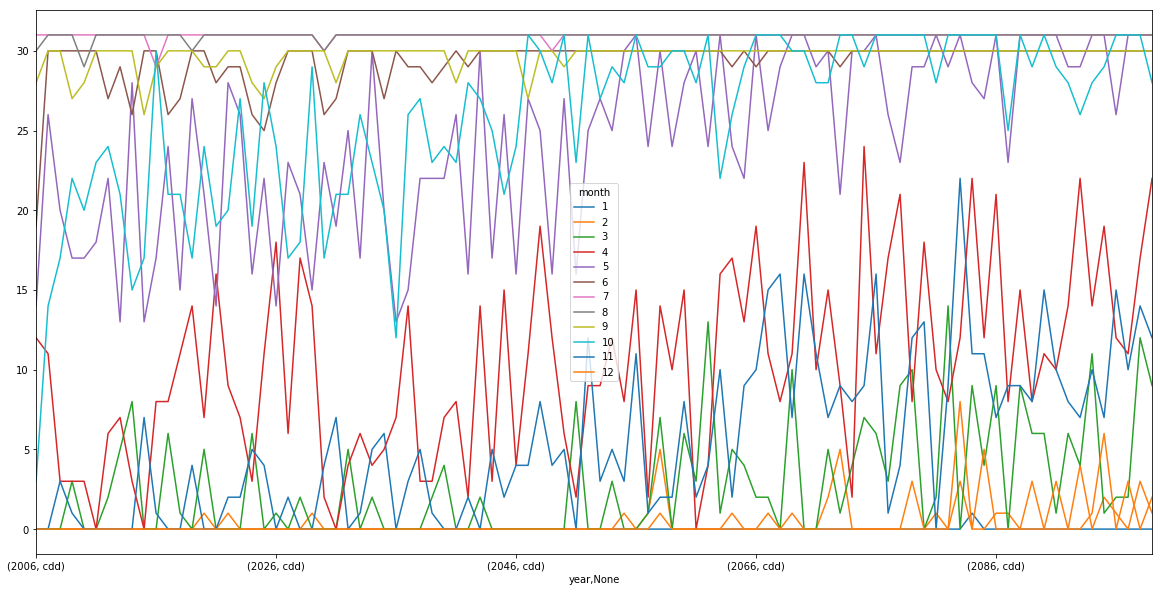

In [108]:
cddDF_monthly.plot()